In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import silhouette_score
from IPython.display import clear_output

# Load the CSV File
file_path = "src/data/tournament_decks.csv"
data = pd.read_csv(file_path)
data

,tournamenturl,playername,mainpokemon,secondarypokemon,deckurl,rank,cards
0,https://limitlesstcg.com/tournaments/jp/1839,1-3,milotic,farigiraf,https://limitlesstcg.com/decks/list/jp/27337,1,P#Feebas#3#https://limitlesstcg.com/cards/SSP/...
1,https://limitlesstcg.com/tournaments/jp/1839,だいくん。,raging-bolt,ogerpon,https://limitlesstcg.com/decks/list/jp/27338,2,P#Raging Bolt ex#4#https://limitlesstcg.com/ca...
2,https://limitlesstcg.com/tournaments/jp/1839,omochikun,xatu,espathra,https://limitlesstcg.com/decks/list/jp/27339,3,P#Natu#3#https://limitlesstcg.com/cards/PAR/71...
3,https://limitlesstcg.com/tournaments/jp/1839,セラ,raging-bolt,ogerpon,https://limitlesstcg.com/decks/list/jp/27340,4,P#Raging Bolt ex#4#https://limitlesstcg.com/ca...
4,https://limitlesstcg.com/tournaments/jp/1839,伸び代のペリ,dragapult,NaN,https://limitlesstcg.com/decks/list/jp/27341,5,P#Dreepy#4#https://limitlesstcg.com/cards/TWM/...
...,...,...,...,...,...,...,...
8345,https://limitlesstcg.com/tournaments/jp/2369,ちよっぱ,armarouge,ho-oh,https://limitlesstcg.com/decks/list/jp/35580,12,P#Charcadet#3#https://limitlesstcg.com/cards/S...
8346,https://limitlesstcg.com/tournaments/jp/2369,れつ,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/35581,13,P#Charmander#3#https://limitlesstcg.com/cards/...
8347,https://limitlesstcg.com/tournaments/jp/2369,りーとん,flareon,noctowl,https://limitlesstcg.com/decks/list/jp/35582,14,P#Hoothoot#3#https://limitlesstcg.com/cards/SC...
8348,https://limitlesstcg.com/tournaments/jp/2369,たろ,dragapult,dusknoir,https://limitlesstcg.com/decks/list/jp/35583,15,P#Dreepy#4#https://limitlesstcg.com/cards/TWM/...


In [3]:
# Parse the "cards" column to extract card links, counts, and types as features
def parse_cards_with_types(cards):
    card_list = cards.split('|')
    card_features = {"p": {}, "t": {}, "e": {}}
    for card in card_list:
        parts = card.split('#')
        if len(parts) >= 3:
            card_type = parts[0].lower() # Extract card type (e.g., "pokemon", "trainer", "energy")
            card_link = parts[3]         # Use the card link as the feature
            card_count = int(parts[2])   # Use the card count as the value
            if card_type in card_features:
                card_features[card_type][card_link] = card_count
    return card_features

card_features_with_types = data['cards'].apply(parse_cards_with_types)
card_features_with_types

0       {'p': {'https://limitlesstcg.com/cards/SSP/41'...
1       {'p': {'https://limitlesstcg.com/cards/TEF/123...
2       {'p': {'https://limitlesstcg.com/cards/PAR/71'...
3       {'p': {'https://limitlesstcg.com/cards/TEF/123...
4       {'p': {'https://limitlesstcg.com/cards/TWM/128...
                              ...                        
8345    {'p': {'https://limitlesstcg.com/cards/SSP/32'...
8346    {'p': {'https://limitlesstcg.com/cards/MEW/4':...
8347    {'p': {'https://limitlesstcg.com/cards/SCR/114...
8348    {'p': {'https://limitlesstcg.com/cards/TWM/128...
8349    {'p': {'https://limitlesstcg.com/cards/SVI/84'...
Name: cards, Length: 8350, dtype: object

In [4]:
# Separate features by card type
pokemon_features = card_features_with_types.apply(lambda x: x['p'])
trainer_features = card_features_with_types.apply(lambda x: x['t'])
energy_features = card_features_with_types.apply(lambda x: x['e'])

# Convert each card type into a feature matrix
vectorizer = DictVectorizer(sparse=False)
pokemon_matrix = vectorizer.fit_transform(pokemon_features)
trainer_matrix = vectorizer.fit_transform(trainer_features)
energy_matrix = vectorizer.fit_transform(energy_features)

# Weight the features by card type (adjust weights as needed)
pokemon_weight = 1.0
trainer_weight = 0.3
energy_weight = 0.1

# Combine the weighted feature matrices
import numpy as np
X_combined = np.hstack([
    pokemon_matrix * pokemon_weight,
    trainer_matrix * trainer_weight,
    energy_matrix * energy_weight
])

# Normalize the combined feature matrix
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X_combined)
X_scaled

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(8350, 800))

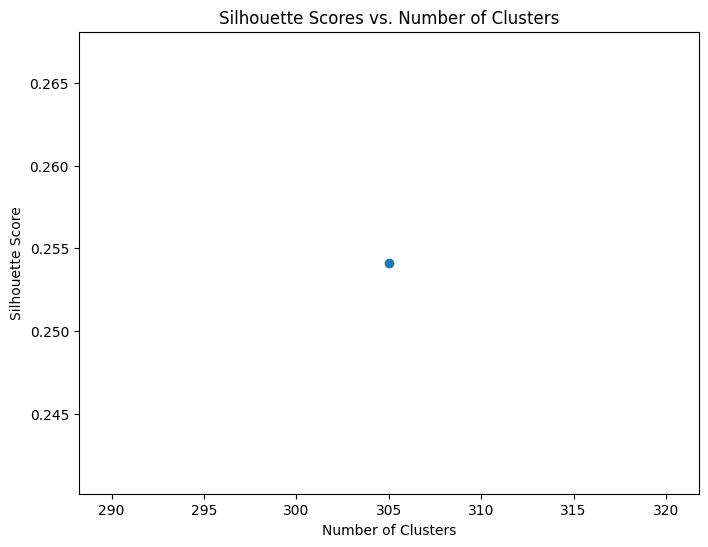

KeyboardInterrupt: 

In [5]:
# Find the optimal number of clusters
start_clusters = 305
end_clusters = 308
silhouette_scores = []
cluster_range = range(start_clusters, end_clusters + 1, 1)
for n_clusters in cluster_range:
    model = AgglomerativeClustering(n_clusters=n_clusters)
    model_result = model.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, model_result))

    if n_clusters % 1 == 0:
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(8, 6))

        # Plot silhouette scores
        ax.plot(range(start_clusters, n_clusters + 1, 1), silhouette_scores, marker='o')
        ax.set_title('Silhouette Scores vs. Number of Clusters')
        ax.set_xlabel('Number of Clusters')
        ax.set_ylabel('Silhouette Score')

        # Show the plots
        plt.show()

# index of max silhouette score
silhouette_scores.index(max(silhouette_scores)) + start_clusters


In [6]:
num_clusters = 306
model = AgglomerativeClustering(n_clusters=num_clusters)
data['cluster'] = model.fit_predict(X_scaled)

In [11]:
# Calculate the median rank for each cluster
cluster_summary = data.groupby('cluster').agg(
    mean_rank=('rank', 'mean'),  # Mean rank of decks in each cluster
    median_rank=('rank', 'median'),  # Median rank of decks in each cluster
    cluster_size=('cluster', 'size'), # Number of decks in each cluster
    main_pokemon=('mainpokemon', lambda x: x.mode()[0] if not x.mode().empty else None),  # Most common main Pokemon
    secondary_pokemon=('secondarypokemon', lambda x: x.mode()[0] if not x.mode().empty else None),  # Most common secondary Pokemon
).reset_index()

# Sort clusters by mean_rank (ascending) to find the best-performing clusters
cluster_summary = cluster_summary.sort_values(by=['mean_rank', 'median_rank'], ascending=[True, True])

cluster_summary[(cluster_summary['cluster_size'] > 30)].head(20)
# cluster_mean_rank[(cluster_mean_rank['main_pokemon'] == 'charizard') & (cluster_mean_rank['secondary_pokemon'] == 'dudunsparce')].head(20)
# cluster_summary[((cluster_summary['main_pokemon'] == 'charizard') | (cluster_summary['secondary_pokemon'] == 'charizard')) & (cluster_summary['cluster_size'] > 10)].head(20)
# cluster_mean_rank[(cluster_mean_rank['cluster'] == 452)].head(20)



,cluster,mean_rank,median_rank,cluster_size,main_pokemon,secondary_pokemon
10,10,7.529412,7.5,34,flareon,noctowl
48,48,7.600000,7.0,60,milotic,farigiraf
71,71,7.702703,7.0,37,froslass,espathra
18,18,7.950638,8.0,1175,ogerpon,raging-bolt
13,13,8.070640,8.0,453,gardevoir,munkidori
131,131,8.103226,8.0,155,archaludon,squawkabilly
57,57,8.113208,7.0,53,froslass,munkidori
3,3,8.117284,8.0,162,archaludon,dudunsparce
77,77,8.130841,8.0,107,feraligatr,munkidori
112,112,8.173333,8.0,75,charizard,dudunsparce


In [13]:
# Sort values by rank then by tournamenturl
data[data['cluster'] == 21].sort_values(by=['rank', 'tournamenturl'], ascending=[True, False])

,tournamenturl,playername,mainpokemon,secondarypokemon,deckurl,rank,cards,cluster
8206,https://limitlesstcg.com/tournaments/jp/2361,ゆうも,noctowl,ogerpon,https://limitlesstcg.com/decks/list/jp/35442,1,P#Hoothoot#4#https://limitlesstcg.com/cards/SC...,21
7523,https://limitlesstcg.com/tournaments/jp/2318,すけいち,noctowl,ogerpon,https://limitlesstcg.com/decks/list/jp/34763,1,P#Hoothoot#4#https://limitlesstcg.com/cards/SC...,21
7299,https://limitlesstcg.com/tournaments/jp/2304,五円玉,noctowl,ogerpon,https://limitlesstcg.com/decks/list/jp/34542,1,P#Hoothoot#4#https://limitlesstcg.com/cards/SC...,21
7251,https://limitlesstcg.com/tournaments/jp/2301,029,noctowl,ogerpon,https://limitlesstcg.com/decks/list/jp/34494,1,P#Hoothoot#4#https://limitlesstcg.com/cards/SC...,21
5995,https://limitlesstcg.com/tournaments/jp/2220,オーキノ博士,noctowl,ogerpon,https://limitlesstcg.com/decks/list/jp/33253,1,P#Hoothoot#4#https://limitlesstcg.com/cards/SC...,21
...,...,...,...,...,...,...,...,...
3082,https://limitlesstcg.com/tournaments/jp/2035,えみーにょ,noctowl,ogerpon-wellspring,https://limitlesstcg.com/decks/list/jp/30389,16,P#Hoothoot#2#https://limitlesstcg.com/cards/PR...,21
3018,https://limitlesstcg.com/tournaments/jp/2031,とつ,noctowl,ogerpon,https://limitlesstcg.com/decks/list/jp/30325,16,P#Hoothoot#3#https://limitlesstcg.com/cards/SC...,21
2154,https://limitlesstcg.com/tournaments/jp/1977,ベルシー,ogerpon,noctowl,https://limitlesstcg.com/decks/list/jp/29465,16,P#Teal Mask Ogerpon ex#3#https://limitlesstcg....,21
1930,https://limitlesstcg.com/tournaments/jp/1963,めんとす,ogerpon,clefairy,https://limitlesstcg.com/decks/list/jp/29242,16,P#Teal Mask Ogerpon ex#4#https://limitlesstcg....,21
